## Preparation

In [19]:
import  warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# load data
test_result_path = 'dataset/Translation_Test/test_table.csv'
user_info_path = 'dataset/Translation_Test/user_table.csv'
test_result = pd.read_csv(test_result_path)
test_result.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
user_info = pd.read_csv(user_info_path)
user_info.head(5)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


## Experiment Overview
In spanish speaking countries, the displayed language of the site might have a influence on the visitor conversion. In order to test the causality between site language and conversion rate, the scientist setup an experiment as follow:
For control group: display spanish 
For test group: display language based on local language

Make sure to control the noised caused by "unrelated" variables as similar as possible for both groups, these variables are: marketing channel, device, ads channel, browser, sex and age of users.   

Additional sanity check is to see, for users in test group, if their country is not Spain, their records on browser_language should be "Other"; while for users in control group, all user's browser_language should be "ES".

In [4]:
# include sex, age, country information into the test_group and control_group dataframe
#caller.join(other.set_index('key'), on='key')
all_user_info = test_result.join(user_info.set_index('user_id'), on = 'user_id')
all_user_info.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [27]:
# First check, in the original setting which is the control group, did Spain have higher conversion rate 
# than all the other LatAm countries
country_conversion = all_user_info.loc[all_user_info.test == 0 , ['conversion','country']].groupby('country').mean()
#print(type(country_conversion)) # <class 'pandas.core.frame.DataFrame'>
country_conversion = country_conversion.reset_index() # make row names(country) as an independent column
country_conversion = country_conversion.sort_values(by = 'conversion', ascending = False)
country_conversion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 14 to 15
Data columns (total 2 columns):
country       17 non-null object
conversion    17 non-null float64
dtypes: float64(1), object(1)
memory usage: 408.0+ bytes


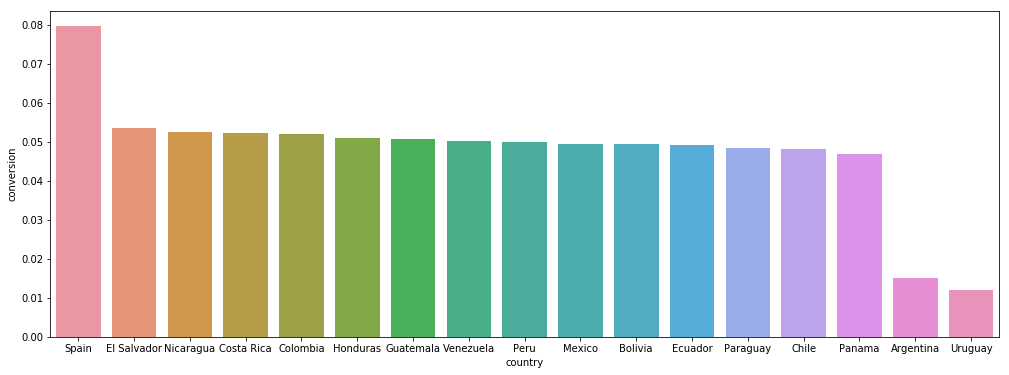

In [29]:
#Visualization of conversion rate over difference countries
fig, ax = plt.subplots(figsize = (country_conversion.shape[0],6))
sns.barplot(x = 'country', y = 'conversion', data = country_conversion, ax = ax)
plt.show()

### As the data scientist found out, Spain does have higher conversion rate than other Spanish-speaking countries.

## Question 1:
### Based on the conversion rate of test and control groups, is it true that the test is negative?

In [36]:
# Separate rows in the test_result dataframe with the test column as 1(test) or 0(control)
test_group = all_user_info.loc[all_user_info['test'] == 1, 'conversion']
control_group = all_user_info.loc[(all_user_info['test'] == 0) & (all_user_info['country'] != 'Spain'), 'conversion']

Well, since nothing changed for users in Spain, there's no users from Spain in the test group, and that is why the query for test and control group is a little bit different.

In [37]:
# sample size of test_group and control_group is
n_test = test_group.shape[0]
n_control = control_group.shape[0]
print([n_test,n_control])

[215983, 185556]


In [38]:
# total number of (user)conversion is
cov_test = test_group.sum()
cov_control = control_group.sum()
print([cov_test,cov_control])

[9379, 8968]


In order to compare the delta of conversion rates between test and control group is negative, we need to run a one side **two sample ratio test**. (https://onlinecourses.science.psu.edu/stat414/node/268/)

In [39]:
# conversion rates
p_test = float(cov_test/n_test)
p_control = float(cov_control/n_control)
# delta
delta = p_test - p_control
# theta_square: sample variance of delta
p_pool = float((cov_test+cov_control)/(n_test+n_control))
theta_square = p_pool*(1-p_pool)*(1/n_test + 1/n_control)

In [42]:
print("Conversion Rate of Test Group: ", round(p_test,5))
print("Conversion Rate of Control Group: ", round(p_control, 5))

Conversion Rate of Test Group:  0.04342
Conversion Rate of Control Group:  0.04833


Null Hypothesis H0: delta >= 0

Alternative Hypothesis Ha: delta < 0

Test statistics:
$$ Z = \frac{\delta - 0}{\theta}$$

Reject H0 if $Z <= -Z_{0.95}$ with $95\%$ confidence.

In [41]:
z_statistics = delta/np.sqrt(theta_square)
z_95 = st.norm.ppf(1-0.05) # find Z0.95 with scipy.stats pkg
print([z_statistics, -z_95])

[-7.422021422012666, -1.6448536269514722]


### Since the Z value is smaller than $-Z_{0.95}$, we can come to a conclusion that the delta between test and control group is indeed negative.

## Question 2
### Explain why that might be happening. Are the localized translations really worse?

### The first question we should ask ourself is: have we kept all the un-related sources of variantion the same between the 2 groups of users? 

To check this, we need to see the distribution of users amongst source, device, browser language, ads channel, browser, sex and age. 

For the continuous variable "age", we could use 2 sample Z test to compare the mean of age between 2 groups.

For all the other variables which are categorical in nature, we could use Chi-square test or Fisher's Exact test to compare the difference in variable distribution between 2 groups.

In [50]:
# First remove the users from Spain
data = all_user_info.loc[all_user_info['country'] != 'Spain',:]
data.shape

(401539, 12)